In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
# Load datasets
climate_df = pd.read_excel(r"E:\Michaelmas\BU7156- Analytics in Practice\Group Project\Pineapple dataset\Pineapples\cleaned\climate.xlsx")
# mortality_df = pd.read_excel(r"E:\Michaelmas\BU7156- Analytics in Practice\Group Project\Pineapple dataset\Pineapples\cleaned\Mortality.xlsx")
pest_df = pd.read_excel(r"E:\Michaelmas\BU7156- Analytics in Practice\Group Project\Pineapple dataset\Pineapples\cleaned\Pest.xlsx")
# roots_df = pd.read_excel(r"E:\Michaelmas\BU7156- Analytics in Practice\Group Project\Pineapple dataset\Pineapples\cleaned\Roots.xlsx")

In [3]:
climate_df.dtypes

Time                              object
Date                              object
Week                               int64
Year                               int64
Radiation (W/m2)                 float64
Temperature (°C)                 float64
Average Temperature (°C)         float64
Maximum Temperature (°C)         float64
Minimum Temperature (°C)         float64
Heat Index (°C)                  float64
Relative Humidity (%)            float64
Average Relative Humidity (%)    float64
Maximum Relative Humidity (%)    float64
Minimum Relative Humidity (%)    float64
Soil Humidity (%)                float64
Rain (mm)                        float64
UV index                         float64
Temperature Maximum Limit        float64
Temperature Minimum Limit        float64
Radiation (max)                  float64
Rad +600                         float64
dtype: object

In [4]:
pest_df.dtypes

CODE                                   int64
YEAR                                   int64
MONTH                                 object
Date                          datetime64[ns]
WEEK                                  object
LOT                                    int64
BLOCK                                  int64
AREA                                 float64
COS.                                  object
Date After Forcing            datetime64[ns]
Group                                  int64
Evaluator                             object
Recorder                              object
DDF                                    int64
AGE                                    int64
SAMPLE                                 int64
Thecla_Larva                           int64
Thecla_Nymph                           int64
Thecla_Adult                           int64
Huevo_Unhatched egg                    int64
Huevo_Hatched/Hatching egg             int64
Soldado_Larva                          int64
Soldado_Ny

In [5]:
# Convert the 'Date' column to datetime and format it as 'yyyy-mm-dd' in all DataFrames
for df in [climate_df, pest_df]:
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'],errors='coerce').dt.strftime('%Y-%m-%d')

In [6]:
# Convert Date column to datetime and format
climate_df["Date"] = pd.to_datetime(climate_df["Date"]).dt.strftime('%Y-%m-%d')

climate_agg = climate_df.groupby("Date").agg({
    "Average Temperature (°C)": "mean",  
    "Radiation (W/m2)": "mean",  
    "Rain (mm)": "sum", 
    "UV index": "mean", 
    "Average Relative Humidity (%)" : "mean",
    "Maximum Relative Humidity (%)" : "mean",
    "Minimum Relative Humidity (%)" : "mean",
    "Soil Humidity (%)" : "mean"
}).reset_index()

climate_agg.columns = ["Date", "Average Temperature (°C)", "Radiation (W/m2)", "Rain (mm)", "UV index", "Average Relative Humidity (%)",
                       "Maximum Relative Humidity (%)", "Minimum Relative Humidity (%)", "Soil Humidity (%)"]

print(climate_agg.head())

         Date  Average Temperature (°C)  Radiation (W/m2)  Rain (mm)  \
0  2020-01-01                 26.195000        172.580417        0.6   
1  2020-01-02                 25.692708        164.351250        0.4   
2  2020-01-03                 25.257083        133.892083        0.0   
3  2020-01-04                 25.971458        136.229583        0.0   
4  2020-01-05                 25.545625        165.882917        0.2   

   UV index  Average Relative Humidity (%)  Maximum Relative Humidity (%)  \
0       NaN                      86.223958                      90.714583   
1       NaN                      86.849167                      91.991667   
2       NaN                      74.140625                      80.129167   
3       NaN                      82.550625                      84.083333   
4       NaN                      82.071667                      88.037500   

   Minimum Relative Humidity (%)  Soil Humidity (%)  
0                      80.812500          87.70604

In [7]:
climate_agg["Date"] = pd.to_datetime(climate_agg["Date"])  # Ensure it's datetime
climate_agg["Year-Month"] = climate_agg["Date"].dt.to_period("M")  # Extract YYYY-MM format

# unique months
unique_months = climate_agg["Year-Month"].unique()
print("Unique months in the data:", unique_months)

Unique months in the data: <PeriodArray>
['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07',
 '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02',
 '2021-03', '2021-04', '2021-05', '2021-07', '2021-09', '2021-10', '2021-11',
 '2021-12', '2022-01', '2022-02', '2022-03', '2023-01', '2023-02', '2023-03',
 '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10',
 '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05',
 '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11']
Length: 48, dtype: period[M]


In [8]:
climate_agg["Date"] = climate_agg["Date"].dt.strftime('%Y-%m-%d')

In [9]:
climate_agg.dtypes

Date                                object
Average Temperature (°C)           float64
Radiation (W/m2)                   float64
Rain (mm)                          float64
UV index                           float64
Average Relative Humidity (%)      float64
Maximum Relative Humidity (%)      float64
Minimum Relative Humidity (%)      float64
Soil Humidity (%)                  float64
Year-Month                       period[M]
dtype: object

In [10]:
# Merge Pest & Climate dataset
pc_merged_df = pd.merge(climate_agg, pest_df, on='Date', how='inner')

In [11]:
pc_merged_df.head()

,Date,Average Temperature (°C),Radiation (W/m2),Rain (mm),UV index,Average Relative Humidity (%),Maximum Relative Humidity (%),Minimum Relative Humidity (%),Soil Humidity (%),Year-Month,...,Soldado_Adult,Soldado_Pupa,Estado G Soldado 1,Estado G Soldado 2,Estado G Soldado 3,Estado G Soldado 4,Estado G Soldado 5,Scale insect,Rodents,Weevil Damage
0,2023-01-02,23.675,100.645833,31.5,0.607292,NaN,NaN,NaN,NaN,2023-01,...,5,0,0,0,0,0,0,1,0,0
1,2023-01-02,23.675,100.645833,31.5,0.607292,NaN,NaN,NaN,NaN,2023-01,...,7,0,0,0,0,0,0,0,0,0
2,2023-01-02,23.675,100.645833,31.5,0.607292,NaN,NaN,NaN,NaN,2023-01,...,6,0,0,0,0,0,0,1,0,0
3,2023-01-02,23.675,100.645833,31.5,0.607292,NaN,NaN,NaN,NaN,2023-01,...,5,0,0,0,0,0,0,1,0,0
4,2023-01-02,23.675,100.645833,31.5,0.607292,NaN,NaN,NaN,NaN,2023-01,...,4,0,0,0,0,0,0,0,0,0


In [12]:
pc_merged_df["Date"] = pd.to_datetime(pc_merged_df["Date"]) 
pc_merged_df["Year-Month"] = pc_merged_df["Date"].dt.to_period("M") 

#unique months
unique_months = pc_merged_df["Year-Month"].unique()
print("Unique months in the data:", unique_months)

Unique months in the data: <PeriodArray>
['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07',
 '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02',
 '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09',
 '2024-10', '2024-11']
Length: 23, dtype: period[M]


In [13]:
pc_merged_df.columns

Index(['Date', 'Average Temperature (°C)', 'Radiation (W/m2)', 'Rain (mm)',
       'UV index', 'Average Relative Humidity (%)',
       'Maximum Relative Humidity (%)', 'Minimum Relative Humidity (%)',
       'Soil Humidity (%)', 'Year-Month', 'CODE', 'YEAR', 'MONTH', 'WEEK',
       'LOT', 'BLOCK', 'AREA', 'COS.', 'Date After Forcing', 'Group',
       'Evaluator', 'Recorder', 'DDF ', 'AGE', 'SAMPLE', 'Thecla_Larva',
       'Thecla_Nymph', 'Thecla_Adult', 'Huevo_Unhatched egg',
       'Huevo_Hatched/Hatching egg', 'Soldado_Larva', 'Soldado_Nymph',
       'Soldado_Adult', 'Soldado_Pupa', 'Estado G Soldado 1',
       'Estado G Soldado 2', 'Estado G Soldado 3', 'Estado G Soldado 4',
       'Estado G Soldado 5', 'Scale insect', 'Rodents', 'Weevil Damage'],
      dtype='object')

In [14]:
pc_merged_df['YEAR'].unique()

array([2023, 2024], dtype=int64)

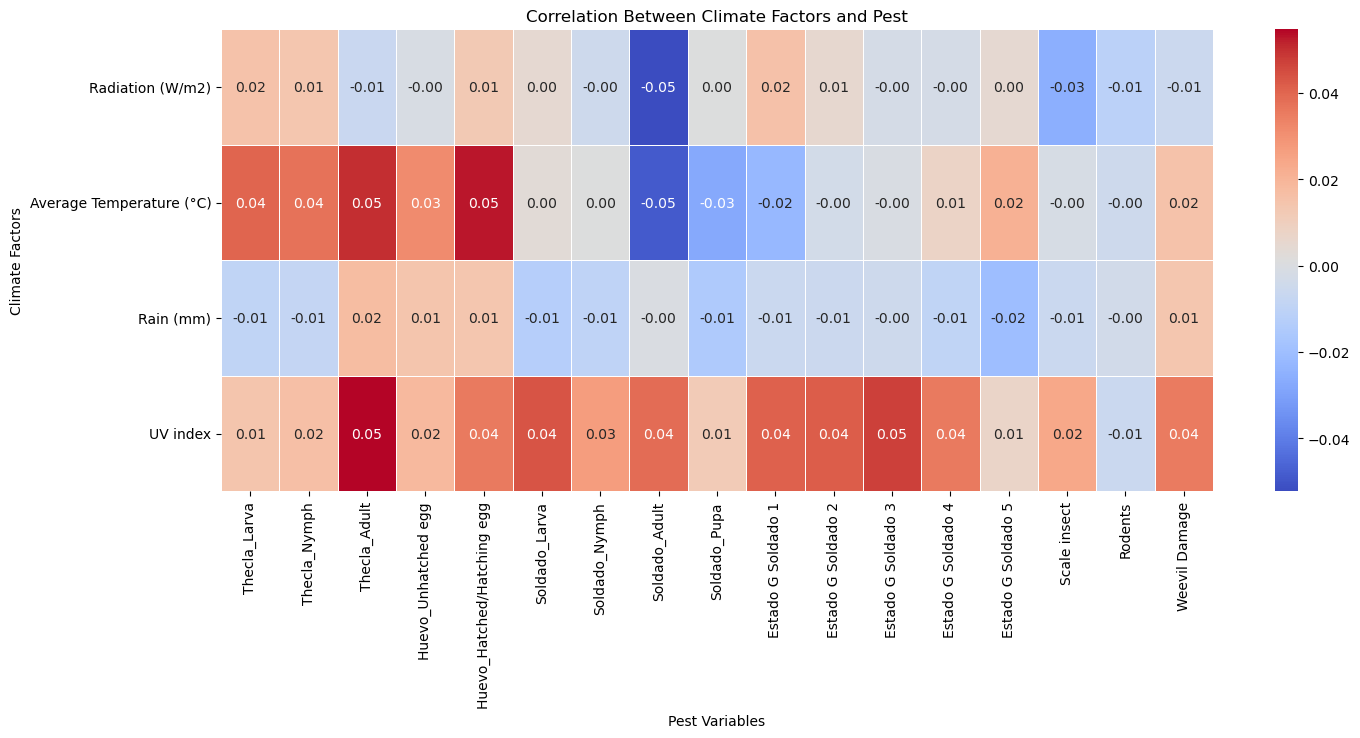

In [15]:
climate_factors = [
    "Radiation (W/m2)", "Average Temperature (°C)", "Rain (mm)", "UV index"
]

pests = [ 
    "Thecla_Larva", "Thecla_Nymph", "Thecla_Adult", "Huevo_Unhatched egg", "Huevo_Hatched/Hatching egg", 
    "Soldado_Larva", "Soldado_Nymph", "Soldado_Adult", "Soldado_Pupa", "Estado G Soldado 1", "Estado G Soldado 2",
    "Estado G Soldado 3", "Estado G Soldado 4", "Estado G Soldado 5", "Scale insect", "Rodents", "Weevil Damage"
]

selected_columns = climate_factors + pests
filtered_df = pc_merged_df[selected_columns]

filtered_df = filtered_df.dropna()

correlation_matrix = filtered_df.corr()

# Extract correlations between climate factors and pest 
correlation_subset = correlation_matrix.loc[climate_factors, pests]

# Plot
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_subset, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Climate Factors and Pest")
plt.xlabel("Pest Variables")
plt.ylabel("Climate Factors")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

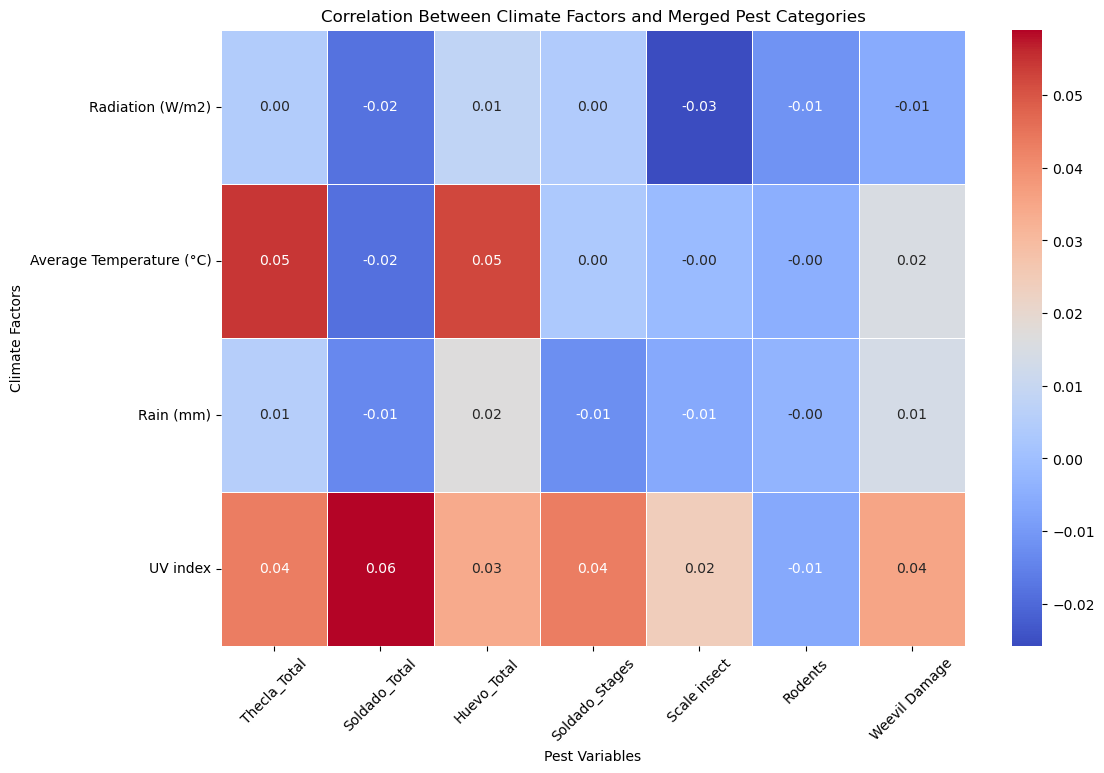

In [16]:
climate_factors = [
    "Radiation (W/m2)", "Average Temperature (°C)", "Rain (mm)", "UV index"
]

# Merge pest categories
pc_merged_df["Thecla_Total"] = pc_merged_df[["Thecla_Larva", "Thecla_Nymph", "Thecla_Adult"]].sum(axis=1)
pc_merged_df["Soldado_Total"] = pc_merged_df[["Soldado_Larva", "Soldado_Nymph", "Soldado_Adult", "Soldado_Pupa"]].sum(axis=1)
pc_merged_df["Huevo_Total"] = pc_merged_df[["Huevo_Unhatched egg", "Huevo_Hatched/Hatching egg"]].sum(axis=1)
pc_merged_df["Soldado_Stages"] = pc_merged_df[["Estado G Soldado 1", "Estado G Soldado 2", 
                                          "Estado G Soldado 3", "Estado G Soldado 4", "Estado G Soldado 5"]].sum(axis=1)

pest_categories = ["Thecla_Total", "Soldado_Total", "Huevo_Total", "Soldado_Stages", "Scale insect", "Rodents", "Weevil Damage"]

# Select only climate factors and new pest categories
selected_columns = climate_factors + pest_categories
filtered_df = pc_merged_df[selected_columns]

filtered_df = filtered_df.dropna()

correlation_matrix = filtered_df.corr()

correlation_subset = correlation_matrix.loc[climate_factors, pest_categories]

# Plot 
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_subset, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Climate Factors and Merged Pest Categories")
plt.xlabel("Pest Variables")
plt.ylabel("Climate Factors")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [17]:
# Merge Pest & Climate dataset
pc_merged_df = pd.merge(climate_agg, pest_df, on='Date', how='inner')

In [18]:
pc_merged_df.columns

Index(['Date', 'Average Temperature (°C)', 'Radiation (W/m2)', 'Rain (mm)',
       'UV index', 'Average Relative Humidity (%)',
       'Maximum Relative Humidity (%)', 'Minimum Relative Humidity (%)',
       'Soil Humidity (%)', 'Year-Month', 'CODE', 'YEAR', 'MONTH', 'WEEK',
       'LOT', 'BLOCK', 'AREA', 'COS.', 'Date After Forcing', 'Group',
       'Evaluator', 'Recorder', 'DDF ', 'AGE', 'SAMPLE', 'Thecla_Larva',
       'Thecla_Nymph', 'Thecla_Adult', 'Huevo_Unhatched egg',
       'Huevo_Hatched/Hatching egg', 'Soldado_Larva', 'Soldado_Nymph',
       'Soldado_Adult', 'Soldado_Pupa', 'Estado G Soldado 1',
       'Estado G Soldado 2', 'Estado G Soldado 3', 'Estado G Soldado 4',
       'Estado G Soldado 5', 'Scale insect', 'Rodents', 'Weevil Damage'],
      dtype='object')

### Total Pest Outbreak Using ARIMA

In [ ]:
# Merge Pest & Climate dataset
pc_merged_df = pd.merge(climate_agg, pest_df, on='Date', how='inner')

In [ ]:
# Aggregate Pest Data
pest_columns = [
    "Thecla_Larva", "Thecla_Nymph", "Thecla_Adult",
    "Huevo_Unhatched egg", "Huevo_Hatched/Hatching egg",
    "Soldado_Larva", "Soldado_Nymph", "Soldado_Adult", "Soldado_Pupa",
    "Estado G Soldado 1", "Estado G Soldado 2", "Estado G Soldado 3",
    "Estado G Soldado 4", "Estado G Soldado 5",
    "Scale insect", "Rodents", "Weevil Damage"
]

# Create a Total Pest Count column
pc_merged_df["Total_Pest_Count"] = pc_merged_df[pest_columns].sum(axis=1)

pc_merged_df["Date"] = pd.to_datetime(pc_merged_df["Date"])
pc_merged_df.set_index("Date", inplace=True)

# Resample to Monthly Totals
pest_monthly = pc_merged_df["Total_Pest_Count"].resample("M").sum()

# Train-Test Split (80% Train, 20% Test)
train_size = int(len(pest_monthly) * 0.8)
train, test = pest_monthly.iloc[:train_size], pest_monthly.iloc[train_size:]

# Train ARIMA Model
order = (1, 1, 1)  
model = ARIMA(train, order=order)
model_fit = model.fit()

#  Make Predictions for the Test Set
test_forecast = model_fit.forecast(steps=len(test))

#  Evaluate Model 
# Compute different error metrics
mae = mean_absolute_error(test, test_forecast)
rmse = np.sqrt(mean_squared_error(test, test_forecast))
mape = mean_absolute_percentage_error(test, test_forecast) * 100
smape = np.mean(2 * np.abs(test_forecast - test) / (np.abs(test) + np.abs(test_forecast))) * 100
r2 = r2_score(test, test_forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")
print(f"R² Score: {r2:.2f}")

forecast_steps = 6
future_forecast = model_fit.forecast(steps=forecast_steps)

future_dates = pd.date_range(start=pest_monthly.index[-1], periods=forecast_steps + 1, freq="M")[1:]

# Create Forecast DataFrame
forecast_df = pd.DataFrame({"Total_Pest_Count_Forecast": future_forecast.values}, index=future_dates)

print("\n 6-Month Pest Outbreak Forecast:")
print(forecast_df)

# Plot 
plt.figure(figsize=(12, 5))
plt.plot(pest_monthly.index, pest_monthly, label="Historical Pest Count", color="blue")
plt.plot(test.index, test, label="Actual Pest Count (Test)", color="green")
plt.plot(test.index, test_forecast, "ro--", label="Test Forecast")
plt.plot(future_dates, future_forecast, "mo--", label="6-Month Forecast")
plt.xlabel("Date")
plt.ylabel("Total Pest Count")
plt.title("Pest Outbreak Forecast Using ARIMA")
plt.legend()
plt.grid()
plt.show()


### Total Pest Outbreak using SARIMA

In [56]:
# Merge Pest & Climate dataset
pc_merged_df = pd.merge(climate_agg, pest_df, on='Date', how='inner')

C:\Users\Arushi\AppData\Local\Temp\ipykernel_29568\3762896263.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pest_monthly = pc_merged_df["Total_Pest_Count"].resample("M").sum()
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Arushi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ADF Test for Total_Pest_Count: p-value = 0.02004
MAE: 7717.00
RMSE: 11311.34
MAPE: 23.56%
SMAPE: 30.20%
R² Score: -1.69

 6-Month Pest Outbreak Forecast:
            Total_Pest_Count_Forecast
2024-12-31                      21759
2025-01-31                      22738
2025-02-28                      29747
2025-03-31                      14667
2025-04-30                      17594
2025-05-31                      12121


C:\Users\Arushi\AppData\Local\Temp\ipykernel_29568\3762896263.py:82: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=pest_monthly.index[-1], periods=forecast_steps + 1, freq="M")[1:]


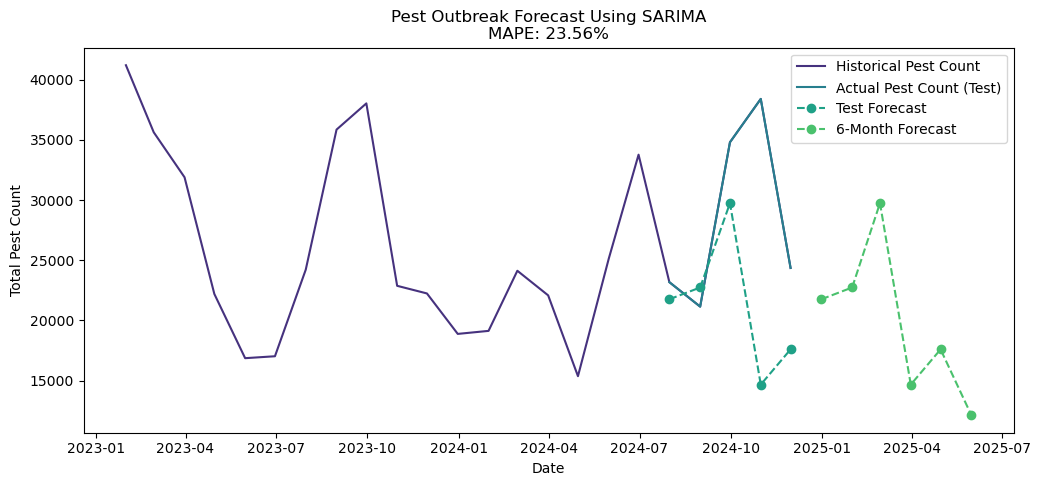

In [57]:
# Set Seaborn color palette to Viridis
sns.set_palette("viridis")

# Aggregate All Pest Data Together
pest_columns = [
    "Thecla_Larva", "Thecla_Nymph", "Thecla_Adult",
    "Huevo_Unhatched egg", "Huevo_Hatched/Hatching egg",
    "Soldado_Larva", "Soldado_Nymph", "Soldado_Adult", "Soldado_Pupa",
    "Estado G Soldado 1", "Estado G Soldado 2", "Estado G Soldado 3",
    "Estado G Soldado 4", "Estado G Soldado 5",
    "Scale insect", "Rodents", "Weevil Damage"
]

pc_merged_df["Total_Pest_Count"] = pc_merged_df[pest_columns].sum(axis=1)

pc_merged_df["Date"] = pd.to_datetime(pc_merged_df["Date"])
pc_merged_df.set_index("Date", inplace=True)

# Resample  to Monthly Totals
pest_monthly = pc_merged_df["Total_Pest_Count"].resample("M").sum()

# Check Stationarity Function
def check_stationarity(series, name):
    adf_test = adfuller(series.dropna())  
    p_value = adf_test[1]
    print(f"ADF Test for {name}: p-value = {p_value:.5f}")
    return p_value > 0.05  

# Define SARIMA Order 
sarima_order = (1, 0, 1)  
seasonal_order = (1, 1, 1, 12)  

# Train-Test Split (80% train, 20% test)
train_size = int(len(pest_monthly) * 0.8)
train, test = pest_monthly.iloc[:train_size], pest_monthly.iloc[train_size:]

if check_stationarity(pest_monthly, "Total_Pest_Count"):
    print("Total_Pest_Count is non-stationary, differencing")
    pest_monthly = pest_monthly.diff().dropna()
    train, test = pest_monthly.iloc[:train_size], pest_monthly.iloc[train_size:]

model = SARIMAX(train, order=sarima_order, seasonal_order=seasonal_order)
model_fit = model.fit()

test_forecast = model_fit.forecast(steps=len(test))

test_forecast.index = test.index  

# Compute different error metrics
mae = mean_absolute_error(test, test_forecast)
rmse = np.sqrt(mean_squared_error(test, test_forecast))
mape = mean_absolute_percentage_error(test, test_forecast) * 100
smape = np.mean(2 * np.abs(test_forecast - test) / (np.abs(test) + np.abs(test_forecast))) * 100
r2 = r2_score(test, test_forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")
print(f"R² Score: {r2:.2f}")

forecast_steps = 6
future_forecast = np.ceil(model_fit.forecast(steps=forecast_steps)).astype(int)

future_dates = pd.date_range(start=pest_monthly.index[-1], periods=forecast_steps + 1, freq="M")[1:]

forecast_df = pd.DataFrame({"Total_Pest_Count_Forecast": future_forecast.values}, index=future_dates)


print("\n 6-Month Pest Outbreak Forecast:")
print(forecast_df)

#  Plot
plt.figure(figsize=(12, 5))
plt.plot(pest_monthly.index, pest_monthly, label="Historical Pest Count", color=sns.color_palette("viridis")[0])
plt.plot(test.index, test, label="Actual Pest Count (Test)", color=sns.color_palette("viridis")[2])
plt.plot(test_forecast.index, test_forecast, "o--", label="Test Forecast", color=sns.color_palette("viridis")[3])
plt.plot(future_dates, future_forecast, "o--", label="6-Month Forecast", color=sns.color_palette("viridis")[4])
plt.xlabel("Date")
plt.ylabel("Total Pest Count")
plt.title(f"Pest Outbreak Forecast Using SARIMA\nMAPE: {mape:.2f}%")
plt.legend()
plt.show()


In [ ]:
# Aggregate All Pest Data Together
pest_columns = [
    "Thecla_Larva", "Thecla_Nymph", "Thecla_Adult",
    "Huevo_Unhatched egg", "Huevo_Hatched/Hatching egg",
    "Soldado_Larva", "Soldado_Nymph", "Soldado_Adult", "Soldado_Pupa",
    "Estado G Soldado 1", "Estado G Soldado 2", "Estado G Soldado 3",
    "Estado G Soldado 4", "Estado G Soldado 5",
    "Scale insect", "Rodents", "Weevil Damage"
]

weather_columns = [
    "Average Temperature (°C)", "Radiation (W/m2)", "Rain (mm)", "UV index"
]

pc_merged_df["Total_Pest_Count"] = pc_merged_df[pest_columns].sum(axis=1)


pc_merged_df["Date"] = pd.to_datetime(pc_merged_df["Date"])
pc_merged_df.set_index("Date", inplace=True)

# Resample to Monthly Totals
pest_monthly = pc_merged_df["Total_Pest_Count"].resample("M").sum()

# Resample Weather Data to Monthly Averages
weather_monthly = pc_merged_df[weather_columns].resample("M").mean()

# Check Stationarity Function
def check_stationarity(series, name):
    adf_test = adfuller(series.dropna()) 
    p_value = adf_test[1]
    print(f"ADF Test for {name}: p-value = {p_value:.5f}")
    return p_value > 0.05 

# Define SARIMA Order (p, d, q) + Seasonal Order (P, D, Q, S)
sarima_order = (1, 0, 1) 
seasonal_order = (1, 1, 1, 12)  

train_size = int(len(pest_monthly) * 0.8)
train, test = pest_monthly.iloc[:train_size], pest_monthly.iloc[train_size:]
train_exog, test_exog = weather_monthly.iloc[:train_size], weather_monthly.iloc[train_size:]

if check_stationarity(pest_monthly, "Total_Pest_Count"):
    print("Total_Pest_Count is non-stationary, applying differencing...")

# Fit SARIMA Model on Training Data with Exogenous Variables
model = SARIMAX(train, exog=train_exog, order=sarima_order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Make Predictions on the Test Set
test_forecast = model_fit.forecast(steps=len(test), exog=test_exog)

#  Compute Different Error Metrics
mae = mean_absolute_error(test, test_forecast)
rmse = np.sqrt(mean_squared_error(test, test_forecast))
mape = mean_absolute_percentage_error(test, test_forecast) * 100
smape = np.mean(2 * np.abs(test_forecast - test) / (np.abs(test) + np.abs(test_forecast))) * 100
r2 = r2_score(test, test_forecast)

# Display Metrics
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")
print(f"R² Score: {r2:.2f}")

forecast_steps = 6
future_exog = weather_monthly.iloc[-forecast_steps:]  # Use last available weather trends for forecast
future_forecast = model_fit.forecast(steps=forecast_steps, exog=future_exog)

future_dates = pd.date_range(start=pest_monthly.index[-1], periods=forecast_steps + 1, freq="M")[1:]

forecast_df = pd.DataFrame({"Total_Pest_Count_Forecast": future_forecast.values}, index=future_dates)


print("\n 6-Month Pest Outbreak Forecast:")
print(forecast_df)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(pest_monthly.index, pest_monthly, label="Historical Pest Count", color="blue")
plt.plot(test.index, test, label="Actual Pest Count (Test)", color="green")
plt.plot(test.index, test_forecast, "ro--", label="Test Forecast")
plt.plot(future_dates, future_forecast, "mo--", label="6-Month Forecast")
plt.xlabel("Date")
plt.ylabel("Total Pest Count")
plt.title(f"Pest Outbreak Forecast Using SARIMA + Weather Data\nMAPE: {mape:.2f}%")
plt.legend()
plt.grid()
plt.show()


C:\Users\Arushi\AppData\Local\Temp\ipykernel_29568\493777752.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_pest_trend = pc_merged_df['Total Pest Count'].resample('M').sum()


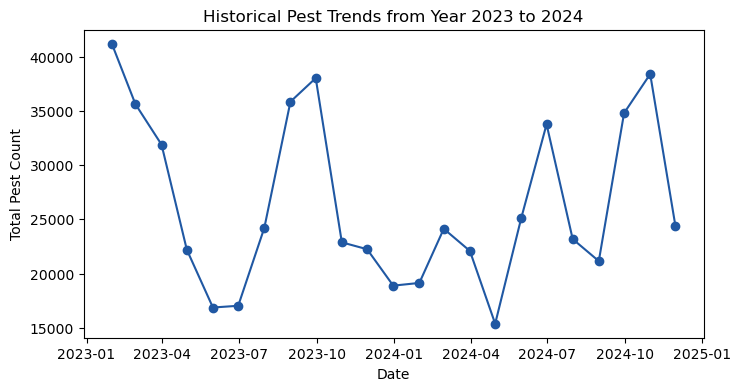

In [28]:
pc_merged_df['Date'] = pd.to_datetime(pc_merged_df['Date'], errors='coerce')

pest_columns = [
    'Thecla_Larva', 'Thecla_Nymph', 'Thecla_Adult', 'Huevo_Unhatched egg',
    'Huevo_Hatched/Hatching egg', 'Soldado_Larva', 'Soldado_Nymph',
    'Soldado_Adult', 'Soldado_Pupa', 'Estado G Soldado 1', 'Estado G Soldado 2',
    'Estado G Soldado 3', 'Estado G Soldado 4', 'Estado G Soldado 5',
    'Scale insect', 'Rodents', 'Weevil Damage'
]

pc_merged_df['Total Pest Count'] = pc_merged_df[pest_columns].sum(axis=1)

pc_merged_df = pc_merged_df.sort_values(by='Date').set_index('Date')

monthly_pest_trend = pc_merged_df['Total Pest Count'].resample('M').sum()

# Plot 
plt.figure(figsize=(8, 4))
plt.plot(monthly_pest_trend, marker='o', linestyle='-', color='#2058A3')
plt.title("Historical Pest Trends from Year 2023 to 2024")
plt.xlabel("Date")
plt.ylabel("Total Pest Count")
plt.show()
